Kaggle Dataset Diabetes, Hypertensionand Stroke Prediction:https://www.kaggle.com/datasets/prosperchuks/health-dataset/data

In [23]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)


In [24]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [25]:
from google.colab import files
'''
uploaded = files.upload("diabetes_data.csv")               # click “Choose Files” and select your CSV
uploaded = files.upload("suffled_diabetes_data.csv")               # click “Choose Files” and select your CSV
data_path = "/content/diabetes_data.csv"
shuffled_data_path = "/content/suffled_diabetes_data.csv"
'''

'\nuploaded = files.upload("diabetes_data.csv")               # click “Choose Files” and select your CSV\nuploaded = files.upload("suffled_diabetes_data.csv")               # click “Choose Files” and select your CSV\ndata_path = "/content/diabetes_data.csv"\nshuffled_data_path = "/content/suffled_diabetes_data.csv"  \n'

In [26]:
import tensorflow as tf
# List physical devices to confirm GPU is available
print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Sun Apr 27 23:23:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             29W /   70W |    2182MiB /  15360MiB |      0%      Default |
|                                         |              

Used to hopefully boost performance using the T4 GPU in google colab

In [27]:
# 0) (Optional) sanity-check that you have a T4
!nvidia-smi --query-gpu=name,driver_version,uuid --format=csv

# 1) Imports + XLA JIT
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)


name, driver_version, uuid
Tesla T4, 550.54.15, GPU-5e60299a-8191-65d4-414c-a4b7c9c5d5ef
Compute dtype: float16
Variable dtype: float32


Used to shuffle the dataset so that the predictions are not unevely measured.

In [28]:
#Change these paths as needed
data_path = "/content/diabetes_data.csv/diabetes_data.csv"
shuffled_data_path =  "/content/suffled_diabetes_data.csv/shuffled_diabetes_data.csv"

In [29]:
# Load the dataset
df = pd.read_csv(data_path)

#Shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Save the shuffled dataframe to a new CSV file
df_shuffled.to_csv(shuffled_data_path, index=False)

# Phase 1

Dataset shape: (70692, 18)
    Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0  10.0  0.0       1.0        1.0  23.0     1.0                   0.0   
1  13.0  0.0       0.0        1.0  33.0     1.0                   0.0   
2   8.0  1.0       1.0        1.0  27.0     1.0                   0.0   
3   7.0  1.0       1.0        1.0  29.0     1.0                   0.0   
4   6.0  1.0       0.0        1.0  47.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      4.0       0.0   
1           0.0     1.0      1.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      2.0       0.0   
3           0.0     1.0      0.0                0.0      3.0       0.0   
4           1.0     1.0      1.0                0.0      4.0      30.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0       0.0       0.0     0.0     0.0  

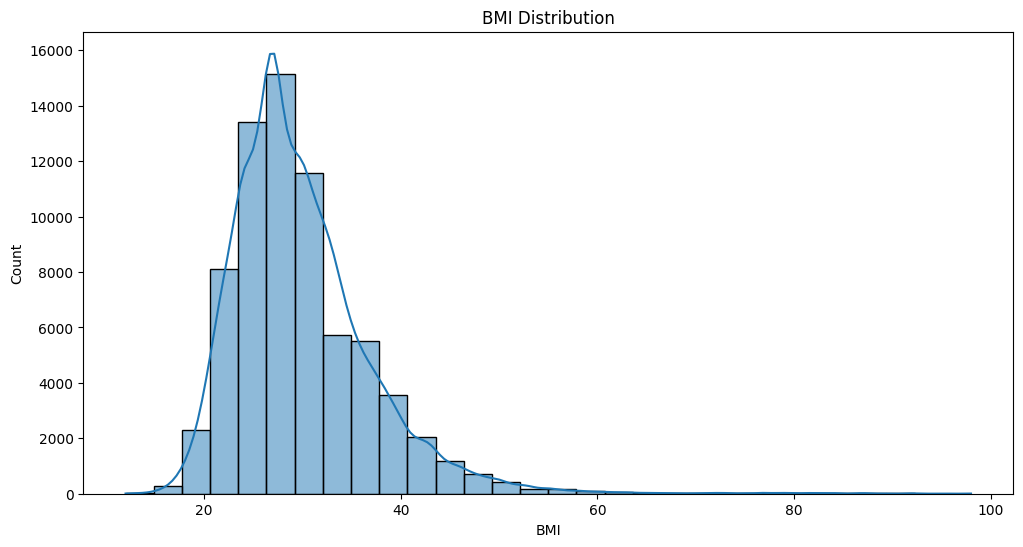

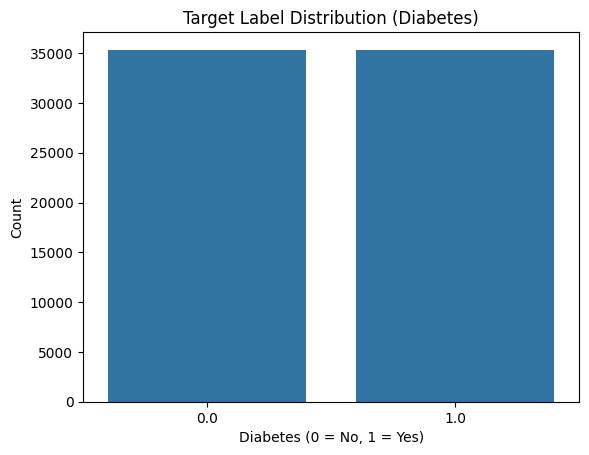

In [30]:

# Display dataset shape and first few rows
print("Dataset shape:", df_shuffled.shape)
print(df_shuffled.head())

# Check for null values
print("\nMissing values:")
print(df_shuffled.isnull().sum())

# Target column: Diabetes (0 or 1)
# Separate features and target
X = df_shuffled.drop(columns=['Diabetes'])
y = df_shuffled['Diabetes']

# Normalize numeric input features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Print resulting shapes
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Plot feature distribution examples
plt.figure(figsize=(12, 6))
sns.histplot(X['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

sns.countplot(x=y)
plt.title('Target Label Distribution (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


# Phase 2

Overfitting the data

In [31]:
# Store results for Phase 2
overfitting_results = []

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True

In [32]:
def build_and_train_overfit_model(hidden_layers, neurons_per_layer, input_dim, epochs=250, batch_size=1024):
    # Build the model
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Train with early stopping
    early_stop = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)
    history = model.fit(
        X_scaled, y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop]
    )

    # Return final accuracy
    final_acc = history.history['accuracy'][-1]
    return model, history, final_acc

In [33]:
# Define configurations
layer_sizes = [7]
neuron_options = [4096]

total_start_time = time.time()
overfitting_results.clear()

# Loop over architectures
for layers in layer_sizes:
    for neurons in neuron_options:
        label = f"{neurons}-neurons x {layers}-layers"
        print(f"Training model: {label}")
        start_time = time.time()
        model, history, final_acc = build_and_train_overfit_model(
            hidden_layers=layers,
            neurons_per_layer=neurons,
            input_dim=X_scaled.shape[1],
            epochs=250,
            batch_size=1024
        )
        elapsed_time = time.time() - start_time
        overfitting_results.append((label, final_acc, elapsed_time))
        print(f"Finished model: {label} in {elapsed_time:.2f} seconds with final training accuracy: {final_acc:.4f}")
        if final_acc >= 0.99:
            break

Training model: 4096-neurons x 7-layers
Epoch 1/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.6524 - loss: 0.6139
Epoch 2/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7449 - loss: 0.5155
Epoch 3/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7502 - loss: 0.5135
Epoch 4/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.7488 - loss: 0.5100
Epoch 5/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7505 - loss: 0.5078
Epoch 6/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7498 - loss: 0.5113
Epoch 7/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7513 - loss: 0.5042
Epoch 8/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.7515 - loss: 0.5027
Epoch 9/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7536 - loss: 0.5021
Epoch 10/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7524 - loss: 0.5038
Epoch 11/250
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.7560 - loss: 0.4985
Epoch 

In [34]:
# Display results
total_elapsed = time.time() - total_start_time
print("\nOverfitting Results:")
for config, acc, t in overfitting_results:
    print(f"{config} => Training Accuracy: {acc:.4f}, Time: {t:.2f} seconds")
print(f"\nTotal training time for all models: {total_elapsed:.2f} seconds")


Overfitting Results:
4096-neurons x 7-layers => Training Accuracy: 0.9471, Time: 2100.92 seconds

Total training time for all models: 2100.92 seconds


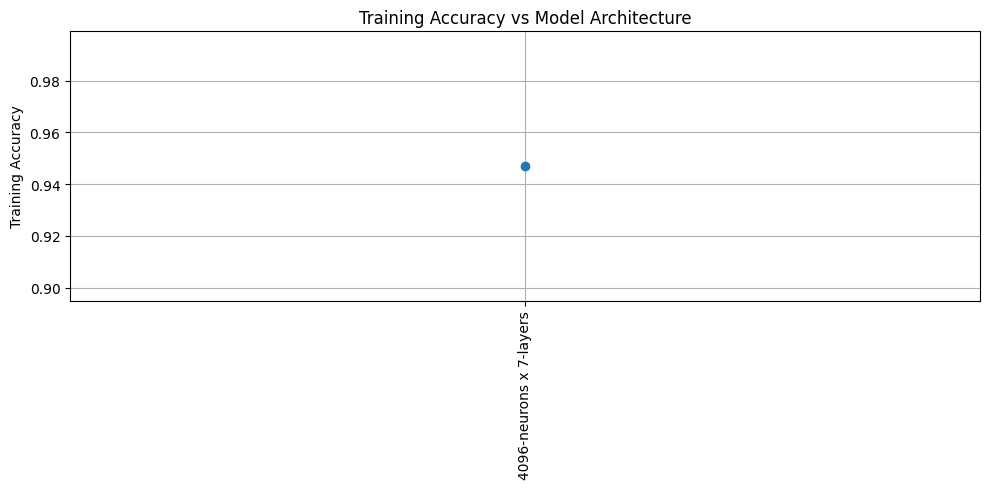

In [35]:
# Plot Accuracy vs Model Configuration
plt.figure(figsize=(10, 5))
configs = [cfg for cfg, _, _ in overfitting_results]
accuracies = [acc for _, acc, _ in overfitting_results]
plt.plot(range(len(configs)), accuracies, marker='o')
plt.xticks(range(len(configs)), configs, rotation=90)
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Model Architecture")
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase 3: Model Selection and Evaluation

In [36]:
# Store evaluation results
evaluation_results = []

# Custom EarlyStoppingByAccuracy callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True

In [37]:
# Function to build and train model for Phase 3
def train_and_evaluate_model_phase3(
    hidden_layers,
    neurons_per_layer,
    input_dim,
    model_name,
    epochs=250,
    batch_size=1024
):
    # Build the model
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        f'{model_name}_best.keras', monitor='val_loss', save_best_only=True, mode='min'
    )
    early_stopping = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)

    # Train directly on NumPy arrays
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    # Predictions and metrics
    preds = np.round(model.predict(X_val)).flatten()
    acc_train = history.history['accuracy'][-1]
    acc_val = accuracy_score(y_val, preds)
    loss_train = history.history['loss'][-1]
    loss_val = BinaryCrossentropy()(y_val, preds).numpy()
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    params = model.count_params()

    # Record results
    evaluation_results.append((
        model_name,
        acc_train,
        acc_val,
        loss_train,
        loss_val,
        precision,
        recall,
        f1,
        params,
        history
    ))


In [38]:
# 1. Random Baseline Classifier
random_preds = np.random.choice([0, 1], size=y_val.shape)
random_acc = accuracy_score(y_val, random_preds)
random_precision = precision_score(y_val, random_preds)
random_recall = recall_score(y_val, random_preds)
random_f1 = f1_score(y_val, random_preds)
random_train_acc = accuracy_score(y_train, np.random.choice([0, 1], size=y_train.shape))
random_train_loss = 1.0
random_val_loss = 1.0
evaluation_results.append((
    "Random Baseline",
    random_train_acc,
    random_acc,
    random_train_loss,
    random_val_loss,
    random_precision,
    random_recall,
    random_f1,
    "-",
    None
))

In [39]:
# 2. Logistic Regression (no hidden layers)
train_and_evaluate_model_phase3(
    hidden_layers=0,
    neurons_per_layer=1,
    input_dim=X_train.shape[1],
    model_name="Logistic Regression"
)

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [40]:
# 3. Neural Network Architectures to Evaluate
architectures = {
  "256-128-64-1":       [256, 128, 64],
  "128-64-32-16-1":     [128,  64, 32, 16],
  "64-64-32-1":         [64,   64, 32],
  "32-32-32-1":         [32,   32, 32],
  "512-1":              [512],
  "16-16-16-16-1":      [16,   16, 16, 16],
  "8-8-8-8-8-1":        [8,     8, 8,  8,  8],
}
for name, layers in architectures.items():
    train_and_evaluate_model_phase3(
        hidden_layers=len(layers),
        neurons_per_layer=layers[0],
        input_dim=X_train.shape[1],
        model_name=name
    )


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [41]:
# Summarize Results
columns = [
    "Model",
    "Acc. on Training Set",
    "Acc. on Validation Set",
    "Loss on Training Set",
    "Loss on Validation Set",
    "Precision",
    "Recall",
    "F1 Score",
    "# Parameters",
    "History"
]
results_df = pd.DataFrame(evaluation_results, columns=columns)


In [42]:
# Display Table
print(results_df.drop(columns=['History']))

                 Model  Acc. on Training Set  Acc. on Validation Set  \
0      Random Baseline              0.499890                0.510325   
1  Logistic Regression              0.746896                0.741443   
2         256-128-64-1              0.889158                0.704102   
3       128-64-32-16-1              0.857738                0.700707   
4           64-64-32-1              0.779432                0.729986   
5           32-32-32-1              0.761388                0.741018   
6                512-1              0.766574                0.739745   
7        16-16-16-16-1              0.755823                0.746535   
8          8-8-8-8-8-1              0.754189                0.748091   

   Loss on Training Set  Loss on Validation Set  Precision    Recall  \
0              1.000000                1.000000   0.510227  0.515134   
1              0.514406                4.142647   0.730489  0.765205   
2              0.238986                4.740186   0.690520  0.7

In [43]:
# Identify Best Model
best_model = results_df.sort_values(by="Acc. on Validation Set", ascending=False).iloc[0]
print("\nBest Performing Model:")
print(best_model.drop(labels='History'))


Best Performing Model:
Model                     8-8-8-8-8-1
Acc. on Training Set         0.754189
Acc. on Validation Set       0.748091
Loss on Training Set           0.5021
Loss on Validation Set       4.036219
Precision                    0.737541
Recall                       0.770297
F1 Score                     0.753563
# Parameters                      441
Name: 8, dtype: object


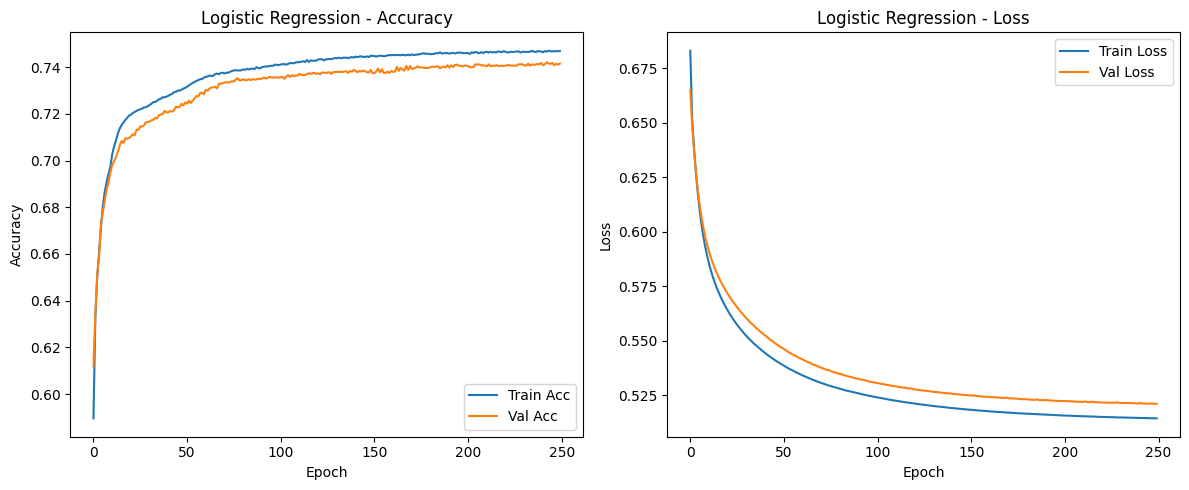

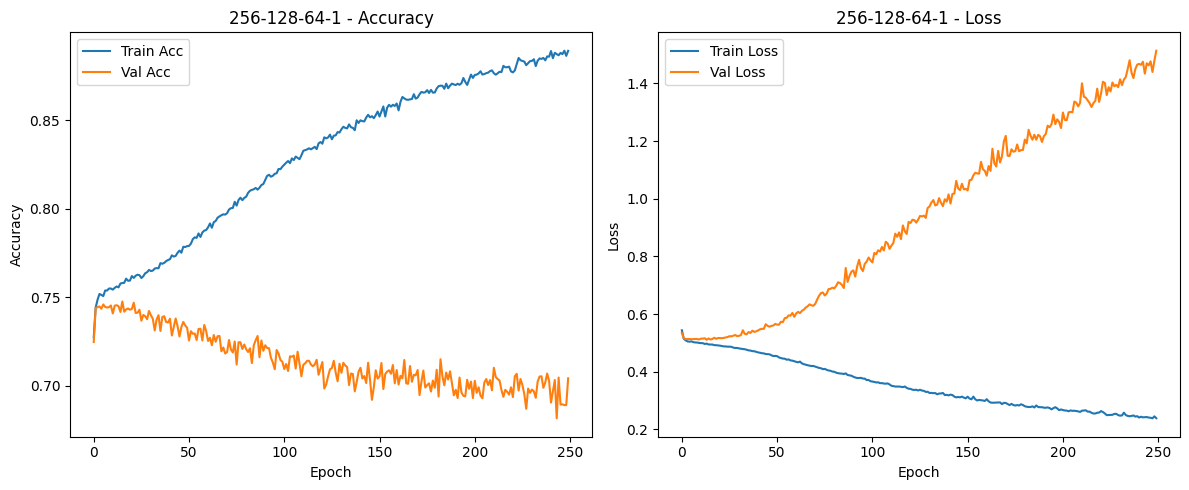

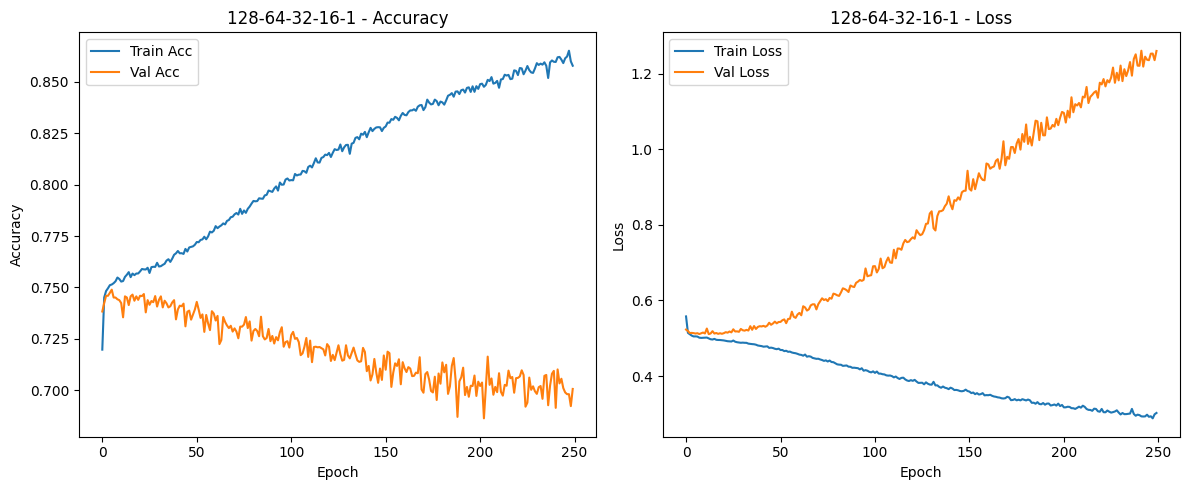

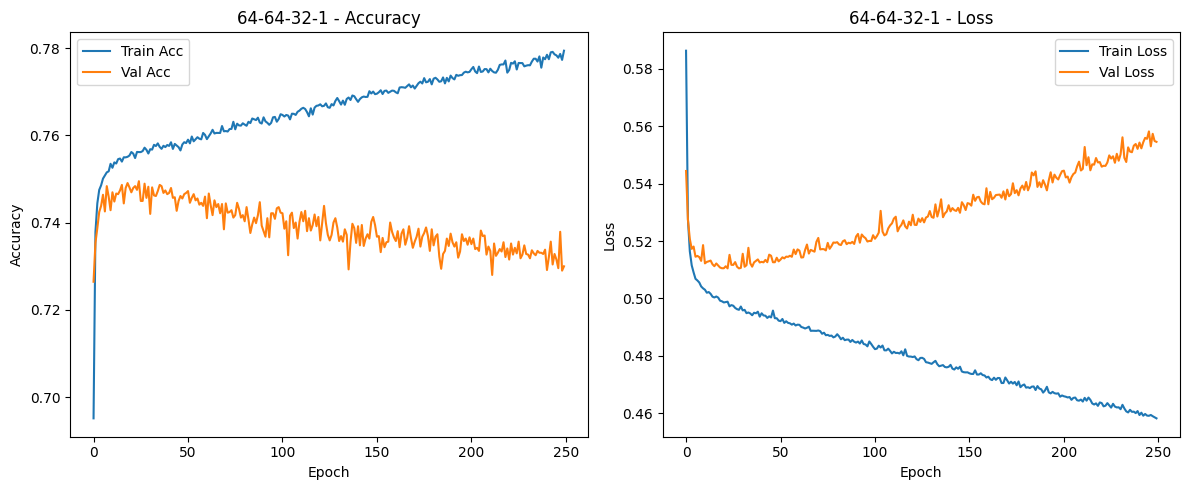

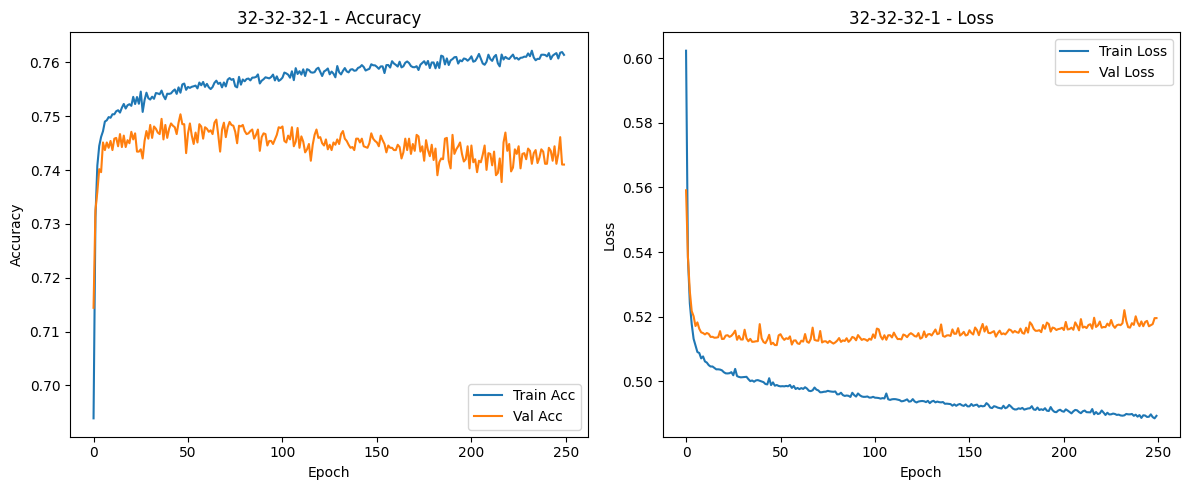

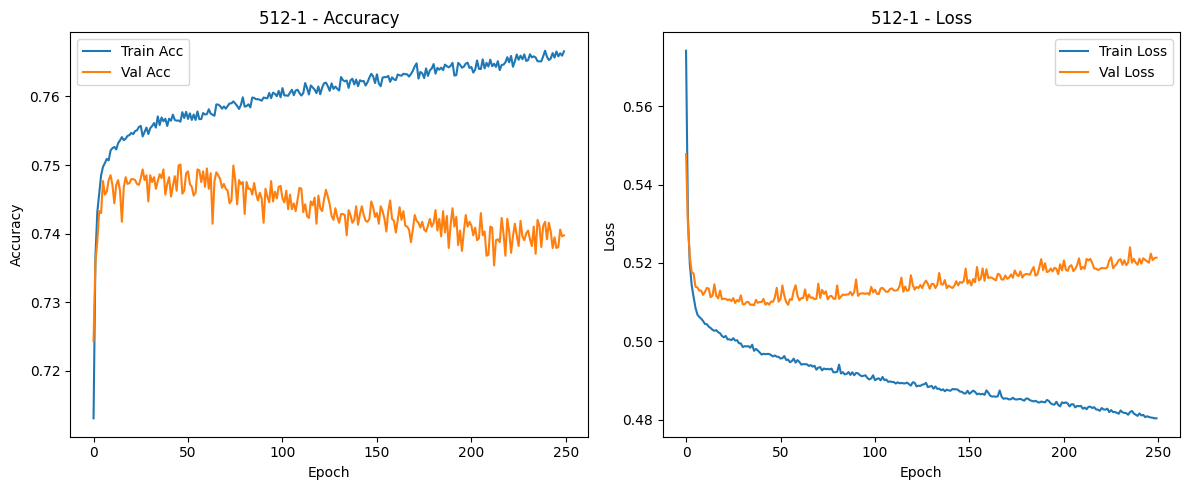

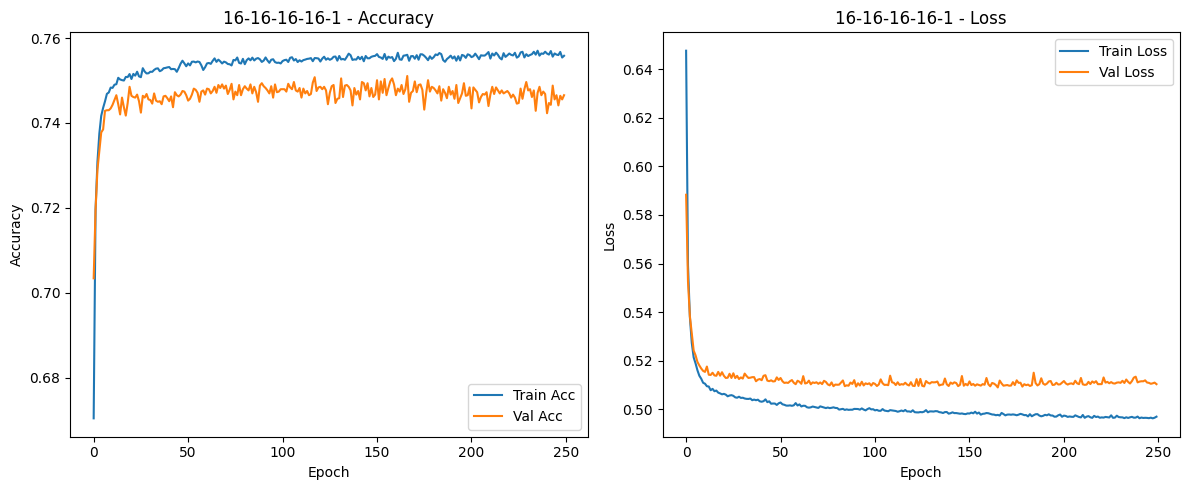

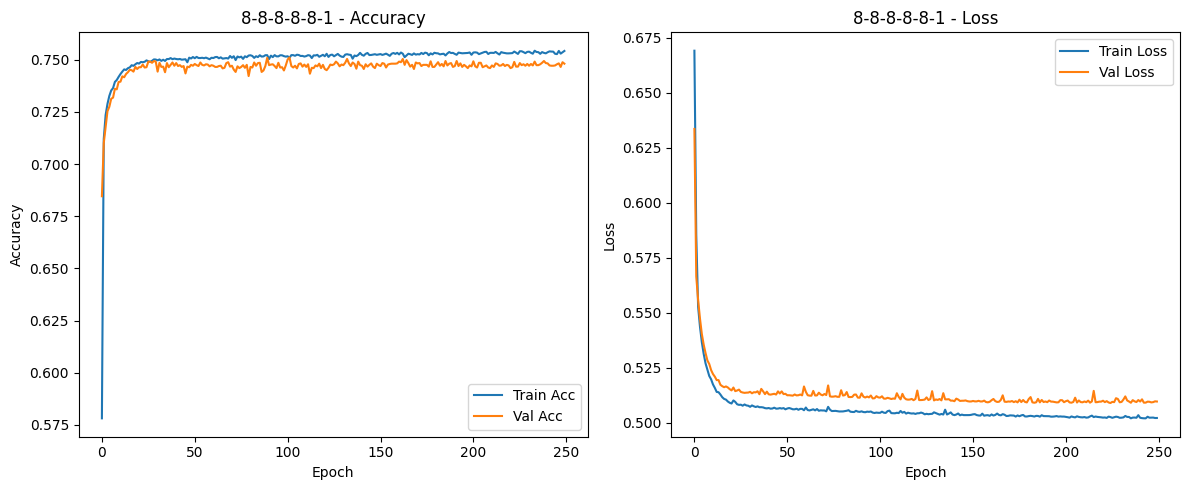

In [44]:
# Plot Learning Curves
for row in evaluation_results:
    name, *_ , history = row
    if history is not None:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f"{name} - Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"{name} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()